In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class PositionalEmbedding(nn.Module):
    def __init__(self, width, max_seq_length):
        super().__init__()

        pe = torch.zeros(max_seq_length, width)

        for pos in range(max_seq_length):
            for i in range(width):
                if i % 2 == 0:
                    pe[pos][i] = np.sin(pos/(10000 ** (i/width)))
                else:
                    pe[pos][i] = np.cos(pos/(10000 ** ((i-1)/width)))

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        x = x + self.pe
        return x

In [3]:
class AttentionHead(nn.Module):
    def __init__(self, width, head_size):
        super().__init__()
        self.head_size = head_size
        
        self.query = nn.Linear(width, head_size)
        self.key = nn.Linear(width, head_size)
        self.value = nn.Linear(width, head_size)

    def forward(self, x, mask=None):
        # 计算K，Q，V
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Q和K的点积
        attention = Q @ K.transpose(-2,-1)
        # 缩放
        attention = attention / (self.head_size ** 0.5)
        # 掩码
        if mask is not None:
            attention = attention.masked_fill(mask == 0, float("-inf"))
        attention = torch.softmax(attention, dim=-1)
        attention = attention @ V
        return attention

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, width, n_heads):
        super().__init__()
        self.head_size = width // n_heads
        self.W_o = nn.Linear(width, width)
        self.heads = nn.ModuleList([
            AttentionHead(width, self.head_size) for _ in range(n_heads)
        ])

    def forward(self, x, mask=None):
        # 拼接多个注意力头
        out = torch.cat([head(x, mask=mask) for head in self.heads], dim=-1)
        out = self.W_o(out)
        return out

In [5]:
class TransformerEncoder(nn.Module):
    def __init__(self, width, n_heads, r_mlp=4):
        super().__init__()
        self.width = width
        self.n_heads = n_heads

        # 层归一化
        self.ln1 = nn.LayerNorm(width)

        # 多头注意力
        self.mha = MultiHeadAttention(width, n_heads)

        # 层归一化
        self.ln2 = nn.LayerNorm(width)

        # MLP
        self.mlp = nn.Sequential(
            nn.Linear(self.width, self.width*r_mlp),
            nn.GELU(),
            nn.Linear(self.width*r_mlp, self.width)
        )

    def forward(self, x, mask=None):
        x = x + self.mha(self.ln1(x), mask=mask)
        x = x + self.mlp(self.ln2(x))
        return x

In [6]:
def tokenizer(text, encode=True, mask=None, max_seq_length=32):
    if encode:
        out = chr(2) + text + chr(3) # 添加 SOT token 和 EOT token
        out = out + "".join([
            chr(0) for _ in range(max_seq_length-len(out))
        ]) # 添加Padding
        out = torch.IntTensor(list(out.encode("utf-8"))) # 对文本进行编码
        mask = torch.ones(len(out.nonzero()))
        mask = torch.cat((
            mask,
            torch.zeros(max_seq_length - len(mask))
        )).type(torch.IntTensor)
    else:
        out = [chr(x) for x in text[1:len(mask.nonzero())-1]]
        out = "".join(out)
        mask = None

    return out, mask

In [7]:
class TextEncoder(nn.Module):
    def __init__(
        self,
        vocab_size, # 词汇表大小=256
        width, # 宽度
        max_seq_length, # 文本最大长度
        n_heads,
        n_layers,
        emb_dim # 嵌入维度
    ):
        super().__init__()
        self.max_seq_length = max_seq_length
        self.encoder_embedding = nn.Embedding(vocab_size, width)
        self.positional_embedding = PositionalEmbedding(width, max_seq_length)
        self.encoder = nn.ModuleList([
            TransformerEncoder(width, n_heads) for _ in range(n_layers)
        ])
        # 可学习投影（projection）
        self.projection = nn.Parameter(torch.randn(width, emb_dim))

    def forward(self, text, mask=None):
        # 文本嵌入
        x = self.encoder_embedding(text)
        # 位置嵌入
        x = self.positional_embedding(x)
        # Transformer编码器
        for encoder_layer in self.encoder:
            x = encoder_layer(x, mask=mask)
        # 从EOT的嵌入抽取特征
        x = x[torch.arange(text.shape[0]), torch.sub(torch.sum(mask[:,0],dim=1),1)]
        # 将文本特征嵌入到联合嵌入空间中（多模态嵌入空间）
        if self.projection is not None:
            x = x @ self.projection

        x = x / torch.norm(x, dim=-1, keepdim=True)
        return x

In [8]:
class ImageEncoder(nn.Module):
    def __init__(
        self,
        width,
        img_size,
        patch_size,
        n_channels,
        n_layers,
        n_heads,
        emb_dim
    ):
        super().__init__()

        assert img_size[0] % patch_size[0] == 0  \
           and img_size[1] % patch_size[1] == 0, \
           "img_size必须能被patch_size整除"
        assert width % n_heads == 0, \
           "width必须能被n_heads整除"

        self.n_patches = (img_size[0] * img_size[1]) \
                      // (patch_size[0] * patch_size[1])
        self.max_seq_length = self.n_patches + 1
        self.linear_project = nn.Conv2d(
            n_channels,
            width,
            kernel_size=patch_size,
            stride=patch_size
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, width))
        self.positional_embedding = PositionalEmbedding(width,self.max_seq_length)
        self.encoder = nn.ModuleList([
            TransformerEncoder(width,n_heads)
            for _ in range(n_layers)
        ])
        
        # 可学习的投影
        self.projection = nn.Parameter(torch.randn(width, emb_dim))

    def forward(self,x):
        # 补丁嵌入
        x = self.linear_project(x)
        x = x.flatten(2).transpose(1, 2)

        # 位置嵌入
        x = torch.cat((self.cls_token.expand(x.size()[0], -1, -1),x), dim=1)
        x = self.positional_embedding(x)

        # Transformer编码器
        for encoder_layer in self.encoder:
            x = encoder_layer(x)

        # 获取类别token
        x = x[:, 0, :]

        # 多模态嵌入
        if self.projection is not None:
            x = x @ self.projection

        x = x / torch.norm(x, dim=-1, keepdim=True)
        return x

In [9]:
class CLIP(nn.Module):
    def __init__(
        self,
        emb_dim,
        vit_width,
        img_size,
        patch_size,
        n_channels,
        vit_layers,
        vit_heads,
        vocab_size,
        text_width,
        max_seq_length,
        text_heads,
        text_layers
    ):
        super().__init__()
        self.image_encoder = ImageEncoder(
            vit_width,
            img_size,
            patch_size,
            n_channels,
            vit_layers,
            vit_heads,
            emb_dim
        )
        self.text_encoder = TextEncoder(
            vocab_size,
            text_width,
            max_seq_length,
            text_heads,
            text_layers,
            emb_dim
        )
        self.temperature = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
        self.device = torch.device("cuda")


    def forward(self,image,text, mask=None):
        I_e = self.image_encoder(image)
        T_e = self.text_encoder(text, mask=mask)

        # 缩放逐点余弦相似度[n, n]
        logits = (I_e @ T_e.transpose(-2,-1)) * torch.exp(self.temperature)

        # 对称损失函数
        labels = torch.arange(logits.shape[0]).to(self.device)

        loss_i = nn.functional.cross_entropy(logits.transpose(-2,-1), labels)
        loss_t = nn.functional.cross_entropy(logits, labels)

        loss = (loss_i + loss_t) / 2

        return loss

In [10]:
class MNIST(Dataset):
    def __init__(self, train=True):
        self.dataset = load_dataset("./../datasets/clip-mnist/")
        self.transform = T.ToTensor()
        if train:
            self.split = "train"
        else:
            self.split = "test"
        
        self.captions = {
            0: "An image of 0",
            1: "An image of 1",
            2: "An image of 2",
            3: "An image of 3",
            4: "An image of 4",
            5: "An image of 5",
            6: "An image of 6",
            7: "An image of 7",
            8: "An image of 8",
            9: "An image of 9"
        }

    def __len__(self):
        return self.dataset.num_rows[self.split]

    def __getitem__(self,i):
        img = self.dataset[self.split][i]["image"]
        img = self.transform(img)
        cap, mask = tokenizer(self.captions[self.dataset[self.split][i]["label"]])
        mask = mask.repeat(len(mask), 1)
        return {"image": img, "caption": cap, "mask": mask}

In [11]:
emb_dim = 32
vit_width = 9
img_size = (28,28)
patch_size = (14,14)
n_channels = 1
vit_layers = 3
vit_heads = 3
vocab_size = 256
text_width = 32
max_seq_length = 32
text_heads = 8
text_layers = 4
lr = 1e-3
epochs = 10
batch_size = 128

In [12]:
train_set = MNIST(train = True)
test_set = MNIST(train = False)

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size)

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [13]:
device = torch.device("cuda")

model = CLIP(
    emb_dim,
    vit_width,
    img_size,
    patch_size,
    n_channels,
    vit_layers,
    vit_heads,
    vocab_size,
    text_width,
    max_seq_length,
    text_heads,
    text_layers
).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

best_loss = np.inf
for epoch in range(epochs):
    for i, data in enumerate(train_loader, 0):
        img = data["image"].to(device)
        cap = data["caption"].to(device)
        mask = data["mask"].to(device)
        loss = model(img, cap, mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Batch Loss: {loss.item():.3f}")

    # 保存模型
    if loss.item() <= best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), "./clip.pt")
        print("模型已经保存.")

Epoch [1/10], Batch Loss: 2.872
模型已经保存.
Epoch [2/10], Batch Loss: 2.730
模型已经保存.
Epoch [3/10], Batch Loss: 2.629
模型已经保存.
Epoch [4/10], Batch Loss: 2.564
模型已经保存.
Epoch [5/10], Batch Loss: 2.583
Epoch [6/10], Batch Loss: 2.648
Epoch [7/10], Batch Loss: 2.459
模型已经保存.
Epoch [8/10], Batch Loss: 2.522
Epoch [9/10], Batch Loss: 2.520
Epoch [10/10], Batch Loss: 2.470


In [14]:
# 加载最好的模型
model = CLIP(
    emb_dim,
    vit_width,
    img_size,
    patch_size,
    n_channels,
    vit_layers,
    vit_heads,
    vocab_size,
    text_width,
    max_seq_length,
    text_heads,
    text_layers
).to(device)
model.load_state_dict(torch.load("./clip.pt", map_location=device))

# 获取数据集的标签和图片进行对比
text = torch.stack([tokenizer(x)[0] for x in test_set.captions.values()]).to(device)
mask = torch.stack([tokenizer(x)[1] for x in test_set.captions.values()])
mask = mask.repeat(1,len(mask[0])).reshape(len(mask),len(mask[0]),len(mask[0])).to(device)

correct, total = 0,0
with torch.no_grad():
    for data in test_loader:
        images, labels = data["image"].to(device), data["caption"].to(device)
        image_features = model.image_encoder(images)
        text_features = model.text_encoder(text, mask=mask)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        _, indices = torch.max(similarity,1)
        pred = torch.stack([tokenizer(test_set.captions[int(i)])[0] for i in indices]).to(device)
        correct += int(sum(torch.sum((pred==labels),dim=1)//len(pred[0])))
        total += len(labels)

print(f'\n预测准确率: {100 * correct // total} %')


预测准确率: 94 %


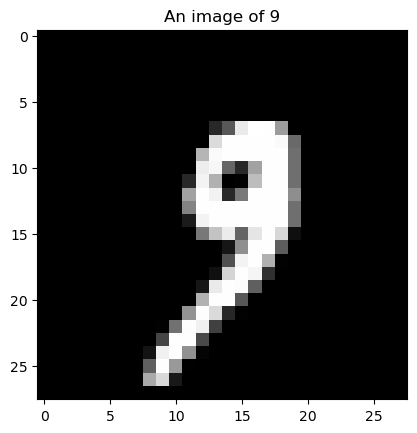


预测结果:

    a image of 9: 100.00%
     a 9 of nine: 0.00%
            asdf: 0.00%
            fdsa: 0.00%
               c: 0.00%


In [26]:
# 加载模型
model = CLIP(
    emb_dim,
    vit_width,
    img_size,
    patch_size,
    n_channels,
    vit_layers,
    vit_heads,
    vocab_size,
    text_width,
    max_seq_length,
    text_heads,
    text_layers
).to(device)
model.load_state_dict(torch.load("./clip.pt", map_location=device))

# 标题
class_names = ["a", "df", "c", "asdf", "fdsa", "xxx", "A Image of xxx", "xy", "yx", "a 9 of nine", "a image of 9"]

text = torch.stack([tokenizer(x)[0] for x in class_names]).to(device)
mask = torch.stack([tokenizer(x)[1] for x in class_names])
mask = mask.repeat(1,len(mask[0])).reshape(len(mask),len(mask[0]),len(mask[0])).to(device)

idx = 1000

img = test_set[idx]["image"][None,:]
plt.imshow(img[0].permute(1, 2, 0)  ,cmap="gray")
plt.title(tokenizer(test_set[idx]["caption"], encode=False, mask=test_set[idx]["mask"][0])[0])
plt.show()
img = img.to(device)
with torch.no_grad():
    image_features = model.image_encoder(img)
    text_features = model.text_encoder(text, mask=mask)

image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# 打印结果
print("\n预测结果:\n")
for value, index in zip(values, indices):
    print(f"{class_names[int(index)]:>16s}: {100 * value.item():.2f}%")